In [1]:
from skimage import io, color
import matplotlib.pyplot as plt
from skimage import exposure
import pylab
import cv2 as cv
# from tqdm import tqdm
import matplotlib.image as mpimg
import numpy as np
import scipy as scp
from PIL import Image, ImageDraw
from scipy.signal import convolve2d
import time
from pyunlocbox import functions
from pyunlocbox import solvers
import pyunlocbox
from skimage import img_as_float
import matplotlib
from skimage.io import imread
from skimage.measure import compare_psnr
matplotlib.use('PDF')
plt.style.use('ggplot') 
%matplotlib inline

# Functions

In [2]:
def FISTA(y, A, norma, tau = 100.):
    if norma == 1:
        f1 = functions.norm_l1(maxit=50, dim=2)
    else:
        f1 = functions.norm_tv(maxit=50, dim=2)
        
    f2 = functions.norm_l2(y =y, A = A, lambda_=tau)
    solver = solvers.forward_backward(step=0.5/tau)
    x0 = np.array(y)  # Make a copy to preserve im_masked.
    ret = solvers.solve([f1, f2], x0, solver, maxit=100)#, verbosity='ALL')
    return ret

def IST(y, A, norma, tau = 100.):
    if norma == 1:
        f1 = functions.norm_l1(maxit=50, dim=2)
    else:
        f1 = functions.norm_tv(maxit=50, dim=2)
        
    f2 = functions.norm_l2(y =y, A = A, lambda_=tau)
 
    x0_IST = np.array(y)  
    solver_IST = solvers.forward_backward(step=0.5/tau, accel = pyunlocbox.acceleration.dummy())
    
    IST = solvers.solve([f1, f2], x0_IST, solver_IST, maxit=100)#, verbosity='ALL')
    return IST

In [3]:
def tv_norm(x):
    h = np.array([0, 1, -1]).reshape(1,-1)
    v = h.T
    h = convolve2d(x, h, boundary='wrap', mode='same')
    v = convolve2d(x, v, boundary='wrap', mode='same')
    return np.sum(np.sqrt(h**2 + v**2))

def soft_1(a, T):
    return np.sign(a)*np.max([abs(a)-T, 0])

soft = np.vectorize(soft_1)

def divergence(p1, p2):
    u = np.empty(p1.shape)
    v = np.empty(p2.shape)
    
    z = p1[1:-1,:] - p1[:-2,:]
    u[0,:] = p1[0,:]
    u[1:-1,:] = z
    u[-1,:] = -p1[-1,:]

    z = p2[:,1:-1] - p2[:,:-2]
    v[:,0] = p2[:,0]
    v[:,1:-1] = z
    v[:,-1] = - p2[:,-1]

    return v + u

def gradient(u):
    z = u[1:, :] - u[:-1,:]
    dux = np.append(z, np.zeros(z.shape[1]).reshape(1,-1), axis = 0)

    z = u[:,1:] - u[:,:-1]
    duy = np.append(z, np.zeros(z.shape[0]).reshape(-1,1), axis = 1)
    
    return dux, duy

def chambolle(x, px, py, threshold=1, max_iter=20, tol=1e-3):
    cont = 1
    k = 0
    tau = 0.249
    
    while cont: 
        k += 1
        divp = divergence(px,py) 
        u = divp - x / threshold
        upx, upy = gradient(u)
        tmp = np.sqrt(upx**2 + upy**2)
        err = np.sum((- upx + tmp * px)**2 + (- upy + tmp * py)**2)**0.5
        px = (px + tau * upx) / (1 + tau * tmp)
        py = (py + tau * upy) / (1 + tau * tmp)
        cont = ((k < max_iter) & (err > tol))

    f = x - threshold * divergence(px, py)
    return f, px, py

In [4]:
def salsa(y, A, AT, tau, mu, true_x, invLS, thres, norma,  max_iter = 100, tolA = 1e-5):
    M, N = y.shape
    
    # initializing
    x = np.zeros(y.shape)
    u = x.copy()
    bu = 0 * u
    if norma == soft:
        psi = soft
        phi = lambda x: np.sum(np.abs(u)) # l1-norm
    else:
        phi = tv_norm
    
    threshold = tau/mu

    # compute and store initial value of the objective function
    resid =  y - A(x)
    resid = np.reshape(resid, order='f', newshape=(resid.shape[0]*resid.shape[1]))
    num_A = 1
    f = [0.5 * (resid.T.dot(resid)) + tau * phi(u)]
    
    mses = [np.sum((x - true_x)**2)/(M*N)]
    
    pux = 0 * u
    puy = 0 * u
    
    for i in range(max_iter):
        if norma == soft:
#             u = psi(x - bu, threshold) # for soft
            u = psi(x - bu, thres) # for soft
        else:
            u, pux, puy = chambolle(np.real(x - bu), pux, puy, threshold, 10)
        r = AT(y) + mu * (u + bu)
        x = invLS(r)
        bu = bu + (u - x)
        resid =  y - A(x)
        resid = np.reshape(resid, order='f', newshape=(resid.shape[0]*resid.shape[1]))
        num_A += 1
        f.append(0.5 * (resid.T.dot(resid)) + tau * phi(u))
        mses.append(np.sum((x - true_x)**2)/(M*N))
        
        if np.abs((f[i+1]-f[i])/f[i]) < tolA:
            return x, f, mses 
    
    return x, f, mses

# Image

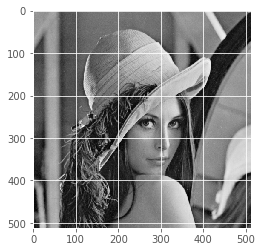

In [5]:
im_original = mpimg.imread('image.jpg')
plt.imshow(im_original, cmap='gray')
im_original = 1.*(im_original - np.min(im_original))/np.max(im_original)

# Part 1: Image deblurring

In [6]:
# Image deblurring, with total variation. 9*9 uniform blur, and Gaussian noise (SNR = 40 dB).

# original image
x = np.array(im_original) 
M, N = x.shape

# function handle for uniform blur operator (acts on the image coefficients)
h = np.ones(9)
lh = len(h)
h = h / np.sum(h);
h = np.append(h, np.zeros(len(x)-len(h)))
h = np.roll(h, -(lh - 1) // 2)
h = h.reshape(-1,1)
h = h.dot(h.T)

H_FFT = np.fft.fft2(h)
HC_FFT = np.conj(H_FFT)

# observation
A = lambda x: np.real(np.fft.ifft2(np.multiply(H_FFT,np.fft.fft2(x))))
AT = lambda x: np.real(np.fft.ifft2(np.multiply(HC_FFT,np.fft.fft2(x))))

# algorithm parameters
tau_1 = 2.5e-2 # reg parameter
mu_1 = tau_1/10.

tau_tv = 0.001 # reg parameter
mu_tv = tau_tv/10.

num_iters = 500
tol = 1e-5

def invLS_mu(mu):
    
    filter_FFT = 1 / (np.abs(H_FFT)**2 + mu)
    invLS = lambda x: np.real(np.fft.ifft2(filter_FFT * np.fft.fft2(x)))
    
    return invLS

SNR = 40
sigma = np.linalg.norm(A(x) - np.mean(A(x)), 'fro') / np.sqrt(N * M * 10**(SNR / 10))
y = A(x) + sigma * np.random.randn(M,N)

______

______

In [7]:
start = time.process_time() 
x_salsa, f, mses = salsa(y, A, AT, tau_tv, mu_tv, x, invLS_mu(mu_tv), 0, norma = tv_norm)
elapsed = (time.process_time() - start)

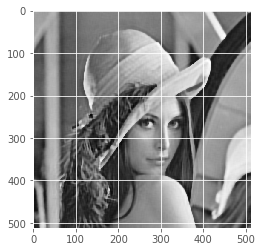

In [8]:
plt.imshow(x_salsa, cmap='gray')

In [9]:
start_soft = time.process_time() 
x_salsa_soft, f_soft, mses_soft = salsa(y, A, AT, tau_1, mu_1, x, invLS_mu(mu_1), 0.0191, norma = soft)
elapsed_soft = (time.process_time() - start_soft)

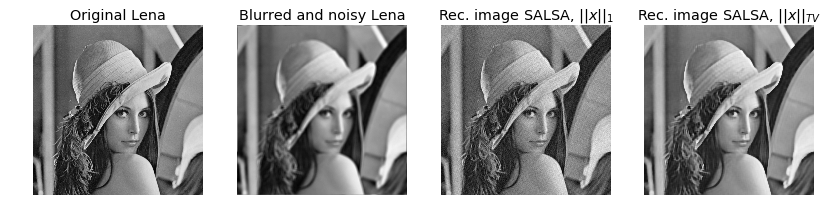

In [10]:
fig = plt.figure(figsize=(14,5))
axes = fig.subplots(1, 4, sharey=True, sharex=True)
axes[0].imshow(x, cmap='gray')
axes[0].set_title('Original Lena')
axes[0].axis('off')
axes[1].imshow(y, cmap='gray')
axes[1].set_title('Blurred and noisy Lena')
axes[1].axis('off')
axes[2].imshow(x_salsa_soft, cmap='gray')
axes[2].set_title('Rec. image SALSA, $\|\| x \|\|_1$')
axes[2].axis('off')
axes[3].imshow(x_salsa, cmap='gray')
axes[3].set_title('Rec. image SALSA, $\|\| x \|\|_{TV}$')
axes[3].axis('off')

plt.savefig('deblur_SALSA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

In [11]:
ret_1norm = FISTA(y, A, norma = 1)

Solution found after 7 iterations:
    objective function f(sol) = 1.071940e+05
    stopping criterion: RTOL


In [12]:
ret_tv_norm = FISTA(y, A, norma = 2)

Solution found after 14 iterations:
    objective function f(sol) = 4.223378e+03
    stopping criterion: RTOL


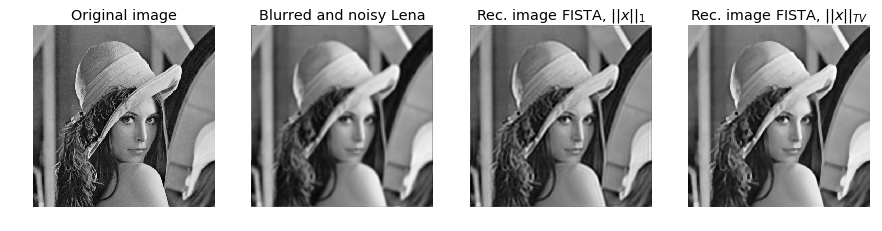

In [13]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy Lena')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image FISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image FISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_debluring'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

In [14]:
ret_1norm_IST = IST(y, A, norma = 1)

Solution found after 7 iterations:
    objective function f(sol) = 1.074863e+05
    stopping criterion: RTOL


In [15]:
ret_tv_norm_IST = IST(y, A, norma = 2)

Solution found after 15 iterations:
    objective function f(sol) = 4.465374e+03
    stopping criterion: RTOL


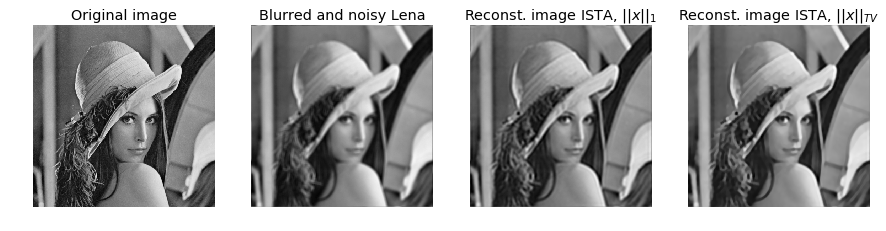

In [16]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original image')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy Lena')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm_IST['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Reconst. image ISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm_IST['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Reconst. image ISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_IST_debluring'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

# Results of part 1

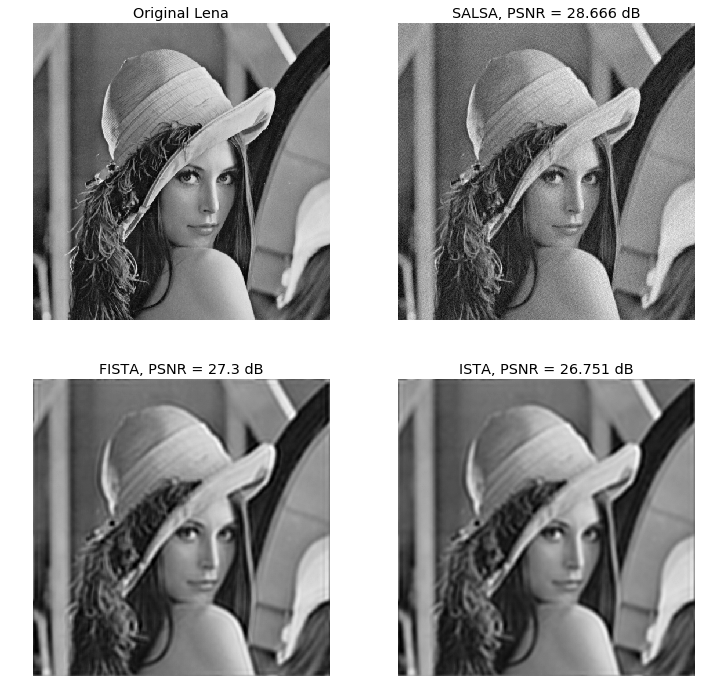

In [17]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(x, cmap='gray')
axes[0][0].set_title('Original Lena')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa_soft, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x, x_salsa_soft), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_1norm['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_1norm_IST['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm_IST['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('1_norm_debluring_comparing'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

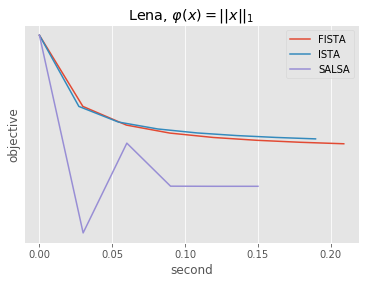

In [18]:
gf_soft = [x + 10.20*10e3  for x in f_soft]
s = gf_soft[0] - ret_1norm['objective'][0][0] - ret_1norm['objective'][0][1]
gf_soft[0] = gf_soft[0] - s
plt.semilogy(np.linspace(0., ret_1norm['time'], ret_1norm['niter']+1), np.sum(ret_1norm['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., ret_1norm_IST['time'], ret_1norm_IST['niter']+1), np.sum(ret_1norm_IST['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 0.15 , len(gf_soft)), gf_soft, label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_1norm_lena'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Lena, $\\varphi(x) = \|\| x \|\|_1$')
plt.show()

In [19]:
gf_soft

[113874.20373935315,
 102000.57738348891,
 107231.06985710177,
 104690.96585012422,
 104684.4588285856,
 104684.4802173385]

In [20]:
ret_1norm['objective']

[[107382.54946374804, 6491.654275605101],
 [106071.82982838413, 3375.485044245603],
 [106072.29643040616, 2243.058966151174],
 [106072.65517478249, 1761.2410732589801],
 [106072.46046463218, 1497.9394545176854],
 [106072.24721084337, 1329.2173764317504],
 [106072.13452225982, 1210.5629573901947],
 [106072.02781626611, 1121.9867520150217]]

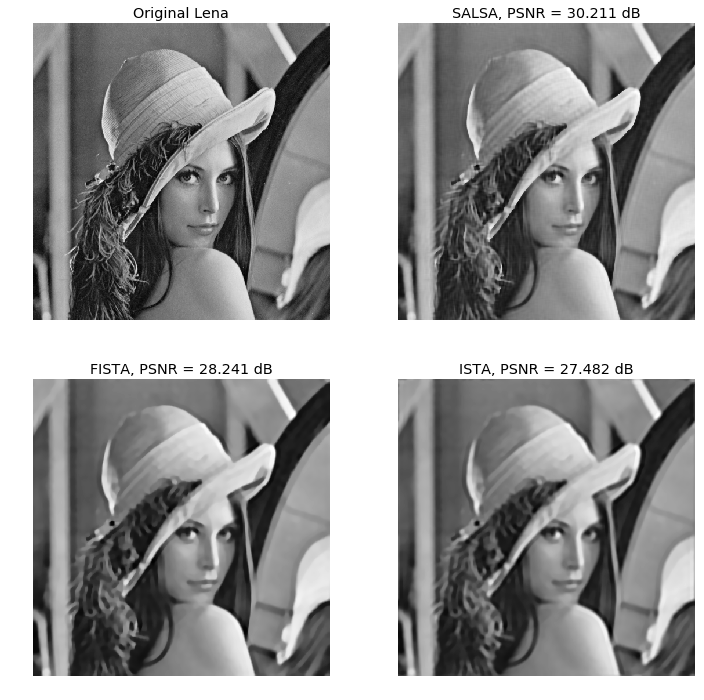

In [21]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(x, cmap='gray')
axes[0][0].set_title('Original Lena')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x,x_salsa), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_tv_norm['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tv_norm['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tv_norm_IST['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tv_norm_IST['sol']), 3)))
axes[1][1].axis('off')


plt.savefig('tv_norm_debluring_comparing'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

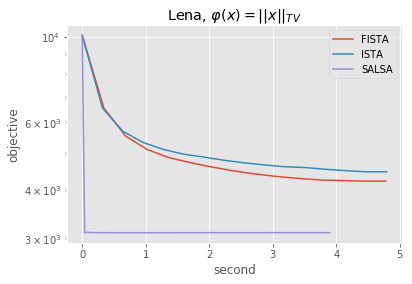

In [22]:
g = [x + 3100  for x in f]
s1 = g[0] - ret_tv_norm['objective'][0][0] - ret_tv_norm['objective'][0][1]
g[0] = g[0] - s1

plt.semilogy(np.linspace(0., ret_tv_norm['time'], ret_tv_norm['niter']+1), np.sum(ret_tv_norm['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., ret_tv_norm_IST['time'], ret_tv_norm_IST['niter']+1), np.sum(ret_tv_norm_IST['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 3.9 , len(f)), g, label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_tv_norm_Lena'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Lena, $\\varphi(x) = \|\| x \|\|_{TV}$')
plt.show()

# Another picture

(512, 512, 3)


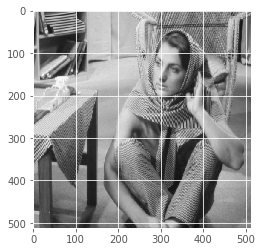

In [23]:
duck = imread('img.jpg')
print(duck.shape)
duck = (duck - np.min(duck))/np.max(duck)
duck = duck[..., 0]
plt.imshow(duck, cmap='gray')

In [24]:
# Image deblurring, with total variation. 9*9 uniform blur, and Gaussian noise (SNR = 40 dB).

# original image
x_duck = np.array(duck) 
M_duck, N_duck = x_duck.shape

# function handle for uniform blur operator (acts on the image coefficients)
h_duck = np.ones(9)
lh_duck = len(h_duck)
h_duck = h_duck / np.sum(h_duck);
h_duck = np.append(h_duck, np.zeros(len(x_duck)-len(h_duck)))
h_duck = np.roll(h_duck, -(lh_duck - 1) // 2)
h_duck = h_duck.reshape(-1,1)
h_duck = h_duck.dot(h_duck.T)

H_FFT_duck = np.fft.fft2(h_duck)
HC_FFT_duck = np.conj(H_FFT_duck)

# observation
A_duck = lambda x_duck: np.real(np.fft.ifft2(np.multiply(H_FFT_duck,np.fft.fft2(x_duck))))
AT_duck = lambda x_duck: np.real(np.fft.ifft2(np.multiply(HC_FFT_duck,np.fft.fft2(x_duck))))

# algorithm parameters
tau_duck_1 = 2.5e-2 # reg parameter
mu_duck_1 = tau_duck_1/10.
num_iters_duck = 500
tol_duck = 1e-5

tau_duck_tv = 0.001 # reg parameter
mu_duck_tv = tau_duck_tv/10.
num_iters_duck = 500
tol_duck = 1e-5

def invLS_mu_duck(mu_duck):
    
    filter_FFT_duck = 1 / (np.abs(H_FFT_duck)**2 + mu_duck)
    invLS_duck = lambda x_duck: np.real(np.fft.ifft2(filter_FFT_duck * np.fft.fft2(x_duck)))
    
    return invLS_duck


SNR_duck = 40
sigma_duck = np.linalg.norm(A_duck(x_duck) - np.mean(A_duck(x_duck)), 'fro') / np.sqrt(N_duck * M_duck * 10**(SNR_duck / 10))
y_duck = A_duck(x_duck) + sigma_duck * np.random.randn(M_duck,N_duck)

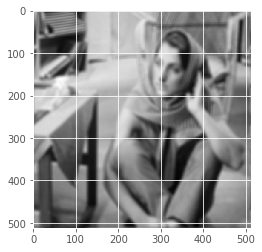

In [25]:
plt.imshow(y_duck, cmap='gray')

### For tv norm

In [26]:
number_iter = 1
i_iter = 0

x_salsa_array_tv = []
f_salsa_array_tv = []
mses_salsa_array_tv = []

ret_tv_norm_FISTA_array = []
ret_tv_norm_IST_array = []


while i_iter < number_iter:
    x_salsa_el, f_el, mses_el = salsa(y_duck, A_duck, AT_duck, tau_duck_tv, mu_duck_tv, x_duck, invLS_mu_duck(mu_duck_tv),0, norma = tv_norm)
    x_salsa_array_tv.append(x_salsa_el)
    f_salsa_array_tv.append(f_el)
    mses_salsa_array_tv.append(mses_el)
    
    
    ret_tv_norm_FISTA_array.append(FISTA(y_duck, A_duck, norma = 2))
    
    ret_tv_norm_IST_array.append(IST(y_duck, A_duck, norma = 2))
    i_iter +=1

Solution found after 13 iterations:
    objective function f(sol) = 4.825082e+03
    stopping criterion: RTOL
Solution found after 15 iterations:
    objective function f(sol) = 5.039200e+03
    stopping criterion: RTOL


In [27]:
array_salsa = np.zeros_like(x_salsa_array_tv[0])

In [28]:
for elem_array in x_salsa_array_tv:
    array_salsa += elem_array

In [29]:
array_salsa = array_salsa/number_iter

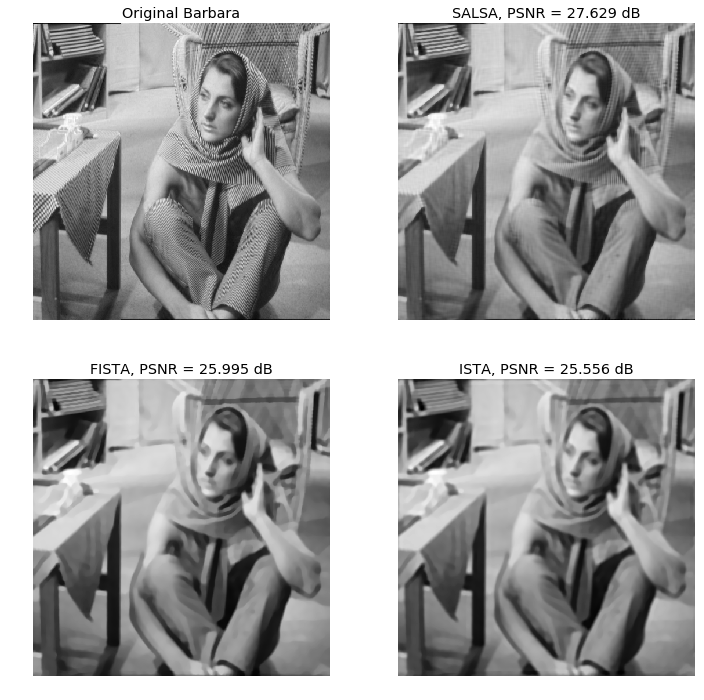

In [30]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(x_duck, cmap='gray')
axes[0][0].set_title('Original Barbara')
axes[0][0].axis('off')
axes[0][1].imshow(array_salsa, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(duck, array_salsa), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_tv_norm_FISTA_array[0]['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret_tv_norm_FISTA_array[0]['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tv_norm_IST_array[0]['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret_tv_norm_IST_array[0]['sol']), 3)))
axes[1][1].axis('off')


plt.savefig('tv_norm_barbara'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

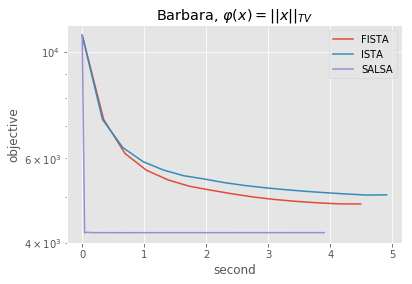

In [31]:
f_el_g = [x + 4200 for x in f_el]
s12 = f_el_g[0] - ret_tv_norm_FISTA_array[0]['objective'][0][0] - ret_tv_norm_FISTA_array[0]['objective'][0][1]
f_el_g [0] = f_el_g [0] - s12

plt.semilogy(np.linspace(0., ret_tv_norm_FISTA_array[0]['time'], ret_tv_norm_FISTA_array[0]['niter']+1), np.sum(ret_tv_norm_FISTA_array[0]['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., ret_tv_norm_IST_array[0]['time'], ret_tv_norm_IST_array[0]['niter']+1), np.sum(ret_tv_norm_IST_array[0]['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 3.9 , len(f_el_g )), f_el_g , label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_barbara_tv_norm'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Barbara, $\\varphi(x) = \|\| x \|\|_{TV}$')
plt.show()

### For 1 norm

In [32]:
number_iter_1norm = 1
i_iter_1norm = 0

x_salsa_array__1norm = []
f_salsa_array__1norm = []
mses_salsa_array__1norm = []

ret__1norm_FISTA_array = []
ret__1norm_IST_array = []


while i_iter_1norm < number_iter_1norm:
    x_salsa_el_1norm, f_el_1norm, mses_el_1norm = salsa(y_duck, A_duck, AT_duck, tau_duck_1, mu_duck_1, x_duck, invLS_mu_duck(mu_duck_1),0.0191, norma = soft)
    x_salsa_array__1norm.append(x_salsa_el_1norm)
    f_salsa_array__1norm.append(f_el_1norm)
    mses_salsa_array__1norm.append(mses_el_1norm)
    
    ret__1norm_FISTA_array.append(FISTA(y_duck, A_duck, norma = 1))
    
    ret__1norm_IST_array.append(IST(y_duck, A_duck, norma = 1))
    i_iter_1norm +=1

Solution found after 7 iterations:
    objective function f(sol) = 1.389051e+05
    stopping criterion: RTOL
Solution found after 6 iterations:
    objective function f(sol) = 1.393786e+05
    stopping criterion: RTOL


In [33]:
array_salsa1 = np.zeros_like(x_salsa_array__1norm[0])
for elem_array1 in x_salsa_array__1norm:
    array_salsa1 += elem_array1
    
array_salsa1 = array_salsa1/number_iter

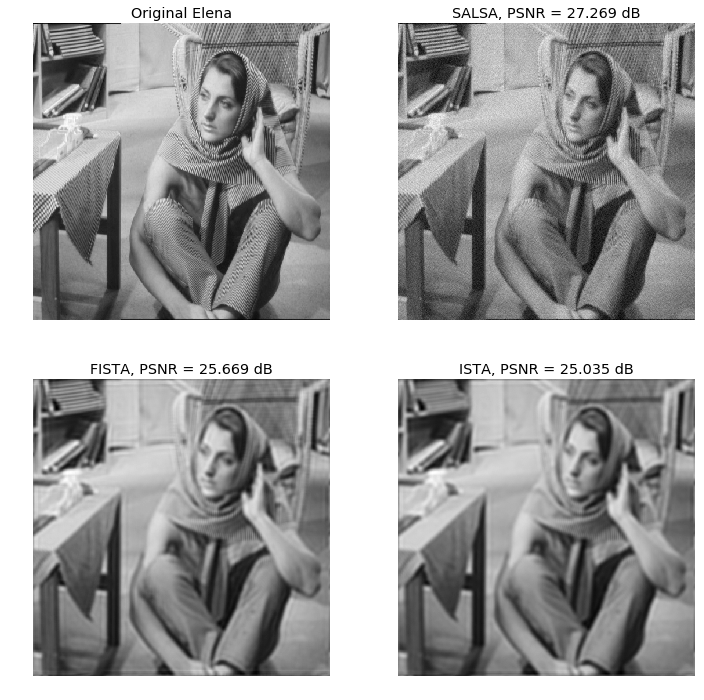

In [34]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(x_duck, cmap='gray')
axes[0][0].set_title('Original Elena')
axes[0][0].axis('off')
axes[0][1].imshow(array_salsa1, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(duck, array_salsa1), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret__1norm_FISTA_array[0]['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret__1norm_FISTA_array[0]['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret__1norm_IST_array[0]['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret__1norm_IST_array[0]['sol']), 3)))
axes[1][1].axis('off')


plt.savefig('first_norm_barbara'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

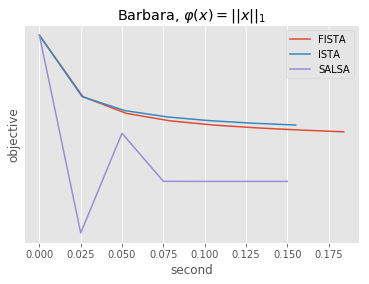

In [35]:
f_el_g1 = [x + 1.32*10e4  for x in f_el_1norm]
s123 = f_el_g1[0] - ret__1norm_FISTA_array[0]['objective'][0][0] - ret__1norm_FISTA_array[0]['objective'][0][1]
f_el_g1[0] = f_el_g1[0] - s123

plt.semilogy(np.linspace(0., ret__1norm_FISTA_array[0]['time'], ret__1norm_FISTA_array[0]['niter']+1), np.sum(ret__1norm_FISTA_array[0]['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., ret__1norm_IST_array[0]['time'], ret__1norm_IST_array[0]['niter']+1), np.sum(ret__1norm_IST_array[0]['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 0.150 , len(f_el_g1 )), f_el_g1 , label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_barbara_1norm'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Barbara, $\\varphi(x) = \|\| x \|\|_{1}$')
plt.show()

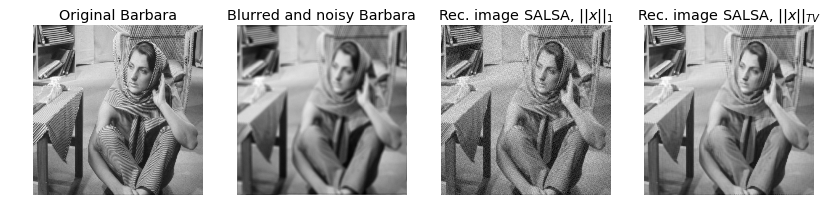

In [36]:
fig = plt.figure(figsize=(14,5))
axes = fig.subplots(1, 4, sharey=True, sharex=True)
axes[0].imshow(x_duck, cmap='gray')
axes[0].set_title('Original Barbara')
axes[0].axis('off')
axes[1].imshow(y_duck, cmap='gray')
axes[1].set_title('Blurred and noisy Barbara')
axes[1].axis('off')
axes[2].imshow(array_salsa1, cmap='gray')
axes[2].set_title('Rec. image SALSA, $\|\| x \|\|_1$')
axes[2].axis('off')
axes[3].imshow(array_salsa, cmap='gray')
axes[3].set_title('Rec. image SALSA, $\|\| x \|\|_{TV}$')
axes[3].axis('off')

plt.savefig('deblur_SALSA_BARBARA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

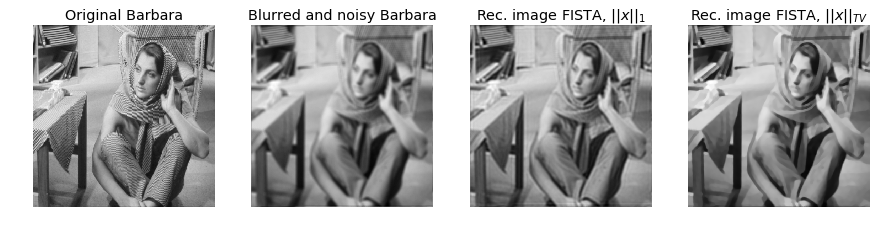

In [37]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x_duck, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Barbara')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y_duck, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy Barbara')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret__1norm_FISTA_array[0]['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image FISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm_FISTA_array[0]['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image FISTA, $\|\| x \|\|_{TV}$')


plt.savefig('FISTA_debluring_BARBARA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

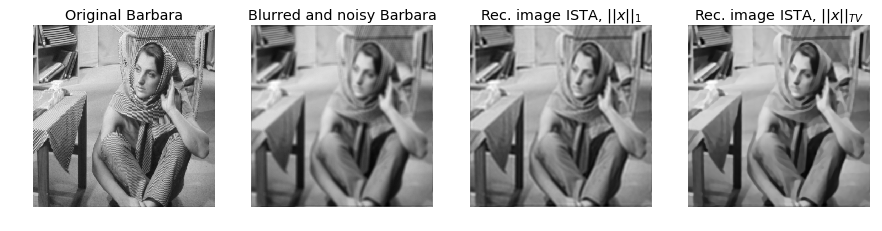

In [38]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x_duck, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Barbara')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(y_duck, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Blurred and noisy Barbara')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret__1norm_IST_array[0]['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image ISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tv_norm_IST_array[0]['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image ISTA, $\|\| x \|\|_{TV}$')


plt.savefig('ISTA_debluring_BARBARA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

# Part 2: mask

In [39]:
x = np.array(im_original)

np.random.seed(14)  # Reproducible results.
mask = np.random.uniform(size=x.shape)
mask = mask > 0.85

g_mask = lambda x: mask * x
im_masked = g_mask(x)

g_T_mask = lambda x: mask * x

tau = 0.111 # reg parameter
mu = tau/10.

invLS = lambda x: 1. / mu * (x - 1. / (1. + mu) * g_T_mask(g_mask(x)))

In [40]:
%%time
started_mask = time.process_time()
x_salsa_mask, f_mask, mses_mask = salsa(im_masked, g_mask, g_T_mask, tau, mu, x, invLS, 0.1, norma=tv_norm)
elapsed_mask = (time.process_time() - started_mask)

CPU times: user 18.9 s, sys: 2.13 s, total: 21 s
Wall time: 10.5 s


In [41]:
ret_tvnorm_mask_FISTA = FISTA(im_masked, g_mask, norma = 2)

Solution found after 87 iterations:
    objective function f(sol) = 4.560741e+03
    stopping criterion: RTOL


In [42]:
ret_tvnorm_mask_ISTA = IST(im_masked, g_mask, norma = 2)

Solution found after 100 iterations:
    objective function f(sol) = 2.093747e+04
    stopping criterion: MAXIT


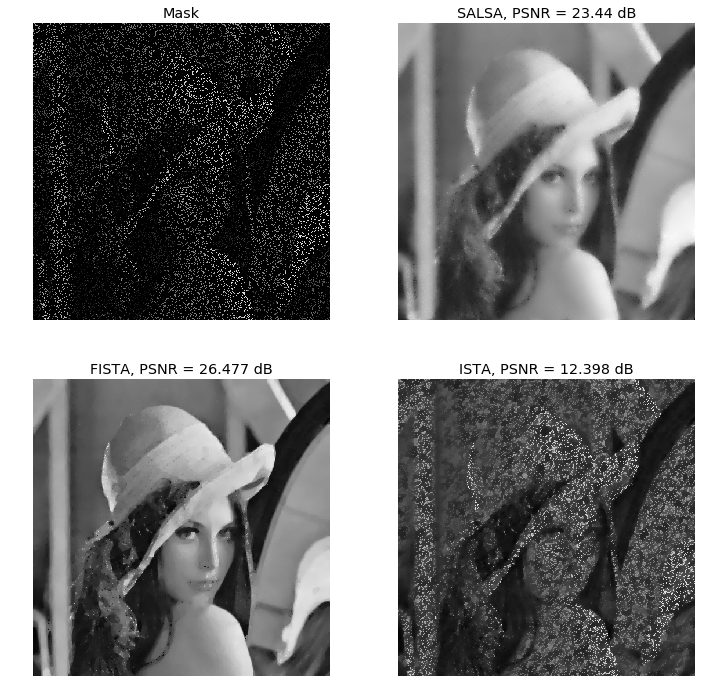

In [43]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(im_masked, cmap='gray')
axes[0][0].set_title('Mask')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa_mask, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x, x_salsa_mask), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_tvnorm_mask_FISTA['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tvnorm_mask_FISTA['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tvnorm_mask_ISTA['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_tvnorm_mask_ISTA['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('mask'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

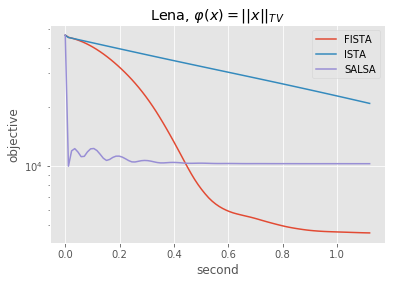

In [44]:
f_mask_g1 = [x + 10*10e2 for x in f_mask]
s3 = f_mask_g1[0] - ret_tvnorm_mask_FISTA['objective'][0][0] - ret_tvnorm_mask_FISTA['objective'][0][1]
f_mask_g1[0] = f_mask_g1[0] - s3

plt.semilogy(np.linspace(0., 1.12, ret_tvnorm_mask_FISTA['niter']+1), np.sum(ret_tvnorm_mask_FISTA['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., 1.12, ret_tvnorm_mask_ISTA['niter']+1), np.sum(ret_tvnorm_mask_ISTA['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 1.12 , len(f_mask_g1 )), f_mask_g1 , label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_mask_lena_tv_norm'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Lena, $\\varphi(x) = \|\| x \|\|_{TV}$')
plt.show()

In [45]:
%%time
#started_mask = time.process_time()
x_salsa_mask_1norm, f_mask_1norm, mses_mask_1norm = salsa(im_masked, g_mask, g_T_mask, tau, mu, x, invLS, 0.1, norma=soft)
#elapsed_mask = (time.process_time() - started_mask)

CPU times: user 12.9 s, sys: 346 ms, total: 13.3 s
Wall time: 11.6 s


In [46]:
ret_1norm_mask_FISTA = FISTA(im_masked, g_mask, norma = 1)
ret_1norm_mask_ISTA = IST(im_masked, g_mask, norma = 1)

Solution found after 2 iterations:
    objective function f(sol) = 1.601896e+04
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 1.601896e+04
    stopping criterion: RTOL


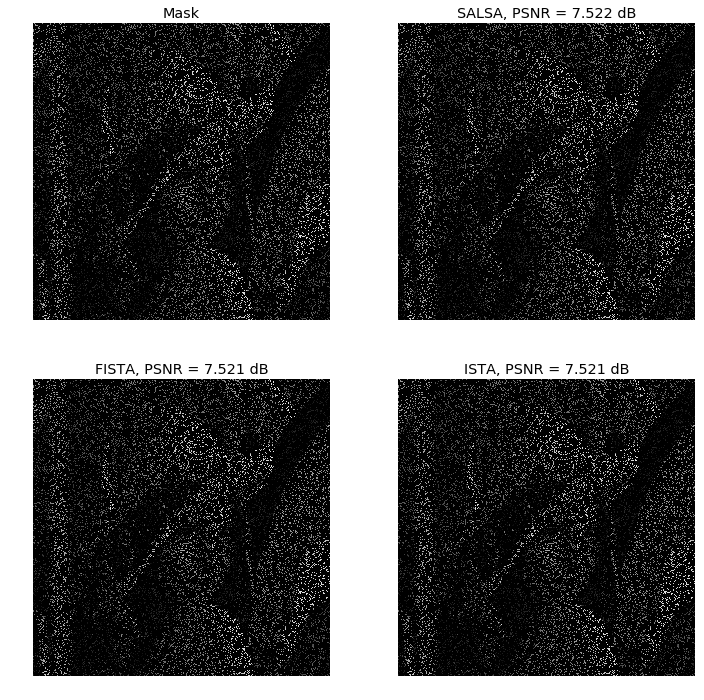

In [47]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(im_masked, cmap='gray')
axes[0][0].set_title('Mask')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa_mask_1norm, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(x, x_salsa_mask_1norm), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_1norm_mask_FISTA['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm_mask_FISTA['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_1norm_mask_ISTA['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(x, ret_1norm_mask_ISTA['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('norma_1_mask'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

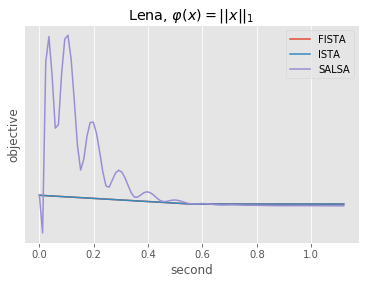

In [48]:
f_mask_g1_tv = [x + 15.7*10e2 for x in f_mask]
s3 = f_mask_g1_tv[0] - ret_1norm_mask_ISTA['objective'][0][0] - ret_1norm_mask_ISTA['objective'][0][1]
f_mask_g1_tv[0] = f_mask_g1_tv[0] - s3

plt.semilogy(np.linspace(0., 1.12, ret_1norm_mask_FISTA['niter']+1), np.sum(ret_1norm_mask_FISTA['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., 1.12, ret_1norm_mask_ISTA['niter']+1), np.sum(ret_1norm_mask_ISTA['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 1.12 , len(f_mask_g1_tv)), f_mask_g1_tv , label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_mask_lena_1_norm'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Lena, $\\varphi(x) = \|\| x \|\|_{1}$')
plt.show()

_______

________

In [49]:
x_barbara = np.array(duck)

np.random.seed(14)  # Reproducible results.
mask_barbara = np.random.uniform(size=x_barbara.shape)
mask_barbara = mask_barbara > 0.85

g_mask_barbara = lambda x_barbara: mask_barbara * x_barbara
im_masked_barbara = g_mask_barbara(x_barbara)

g_T_mask_barbara = lambda x_barbara: mask_barbara * x_barbara

tau_barbara = 0.001 # reg parameter
mu_barbara = tau_barbara/10.

invLS_barbara = lambda x_barbara: 1. / mu_barbara * (x_barbara - 1. / (1. + mu_barbara) * g_T_mask_barbara(g_mask_barbara(x_barbara)))

In [50]:

x_salsa_mask_barbara, f_mask_barbara, mses_mask_barbara = salsa(im_masked_barbara, g_mask_barbara, g_T_mask_barbara, tau_barbara, mu_barbara, duck, invLS_barbara, 0.1, norma=tv_norm)


ret_tvnorm_mask_FISTA_barbara = FISTA(im_masked_barbara, g_mask_barbara, norma = 2)

ret_tvnorm_mask_ISTA_barbara = IST(im_masked_barbara, g_mask_barbara, norma = 2)

Solution found after 92 iterations:
    objective function f(sol) = 5.736953e+03
    stopping criterion: RTOL
Solution found after 100 iterations:
    objective function f(sol) = 3.071436e+04
    stopping criterion: MAXIT


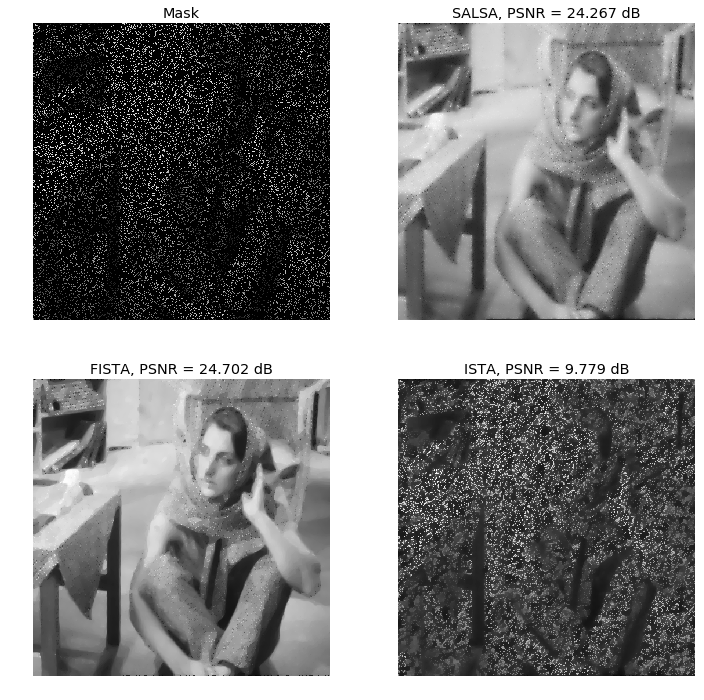

In [51]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(im_masked_barbara, cmap='gray')
axes[0][0].set_title('Mask')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa_mask_barbara, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(duck, x_salsa_mask_barbara), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_tvnorm_mask_FISTA_barbara['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret_tvnorm_mask_FISTA_barbara['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tvnorm_mask_ISTA_barbara['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret_tvnorm_mask_ISTA_barbara['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('mask_tv_barbara'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

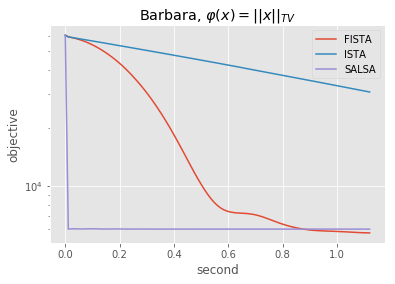

In [52]:
f_mask_g1_barbara = [x + 6*10e2 for x in f_mask_barbara]
s3_barbara = f_mask_g1_barbara[0] - ret_tvnorm_mask_FISTA_barbara['objective'][0][0] - ret_tvnorm_mask_FISTA_barbara['objective'][0][1]
f_mask_g1_barbara[0] = f_mask_g1_barbara[0] - s3_barbara

plt.semilogy(np.linspace(0., 1.12, ret_tvnorm_mask_FISTA_barbara['niter']+1), np.sum(ret_tvnorm_mask_FISTA_barbara['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., 1.12, ret_tvnorm_mask_ISTA_barbara['niter']+1), np.sum(ret_tvnorm_mask_ISTA_barbara['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 1.12 , len(f_mask_g1_barbara )), f_mask_g1_barbara , label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_mask_barbarara_tv_norm'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Barbara, $\\varphi(x) = \|\| x \|\|_{TV}$')
plt.show()

_____

In [53]:
x_salsa_mask_barbara1, f_mask_barbara1, mses_mask_barbara1 = salsa(im_masked_barbara, g_mask_barbara, g_T_mask_barbara, tau_barbara, mu_barbara, duck, invLS_barbara, 0.1, norma=soft)

ret_tvnorm_mask_FISTA_barbara1 = FISTA(im_masked_barbara, g_mask_barbara, norma = 1)

ret_tvnorm_mask_ISTA_barbara1 = IST(im_masked_barbara, g_mask_barbara, norma = 1)

Solution found after 2 iterations:
    objective function f(sol) = 2.071760e+04
    stopping criterion: RTOL
Solution found after 2 iterations:
    objective function f(sol) = 2.071760e+04
    stopping criterion: RTOL


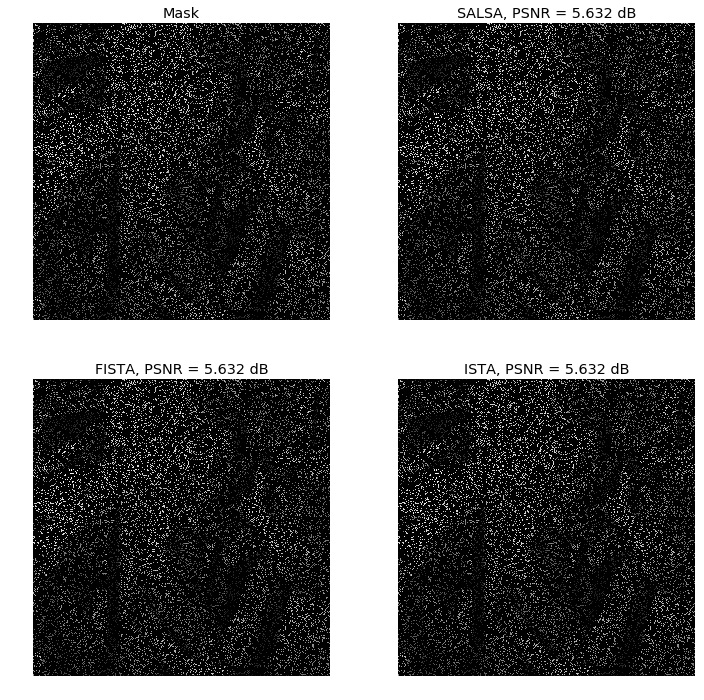

In [54]:
fig = plt.figure(figsize=(12,12))
axes = fig.subplots(2, 2, sharey=True, sharex=True)
axes[0][0].imshow(im_masked_barbara, cmap='gray')
axes[0][0].set_title('Mask')
axes[0][0].axis('off')
axes[0][1].imshow(x_salsa_mask_barbara1, cmap='gray')
axes[0][1].set_title('SALSA, PSNR = {} dB'.format(np.round(compare_psnr(duck, x_salsa_mask_barbara1), 3)))
axes[0][1].axis('off')
axes[1][0].imshow(ret_tvnorm_mask_FISTA_barbara1['sol'], cmap='gray')
axes[1][0].set_title('FISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret_tvnorm_mask_FISTA_barbara1['sol']), 3)))
axes[1][0].axis('off')
axes[1][1].imshow(ret_tvnorm_mask_ISTA_barbara1['sol'], cmap='gray')
axes[1][1].set_title('ISTA, PSNR = {} dB'.format(np.round(compare_psnr(duck, ret_tvnorm_mask_ISTA_barbara1['sol']), 3)))
axes[1][1].axis('off')

plt.savefig('mask_1_barbara'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

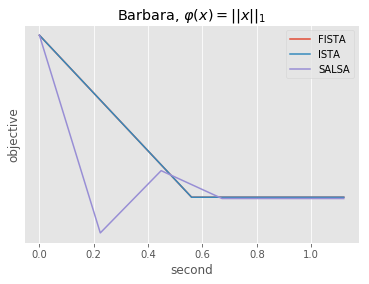

In [55]:
f_mask_g1_barbara1 = [x + 20.696*10e2 for x in f_mask_barbara1]
s3_barbara1 = f_mask_g1_barbara1[0] - ret_tvnorm_mask_FISTA_barbara1['objective'][0][0] - ret_tvnorm_mask_FISTA_barbara1['objective'][0][1]
f_mask_g1_barbara1[0] = f_mask_g1_barbara1[0] - s3_barbara1

plt.semilogy(np.linspace(0., 1.12, ret_tvnorm_mask_FISTA_barbara1['niter']+1), np.sum(ret_tvnorm_mask_FISTA_barbara1['objective'], axis=1), label = 'FISTA')
plt.semilogy(np.linspace(0., 1.12, ret_tvnorm_mask_ISTA_barbara1['niter']+1), np.sum(ret_tvnorm_mask_ISTA_barbara1['objective'], axis=1), label = 'ISTA')
plt.semilogy(np.linspace(0., 1.12 , len(f_mask_g1_barbara1 )), f_mask_g1_barbara1 , label = 'SALSA')
plt.legend()
plt.xlabel('second')
plt.ylabel('objective')
#plt.titile('')

plt.savefig('objective_mask_barbarbra_1_norm'+ '.pdf', format = 'pdf', bbox_inches = 'tight')
plt.title('Barbara, $\\varphi(x) = \|\| x \|\|_{1}$')
plt.show()

_________

______

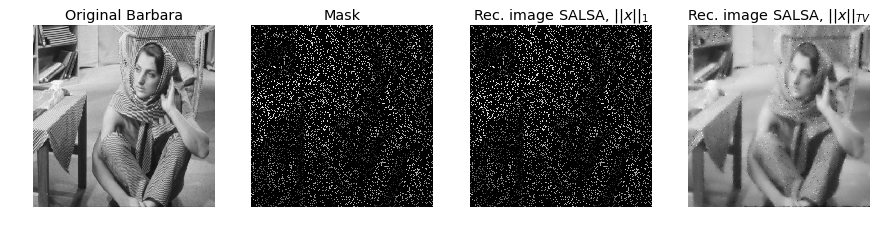

In [56]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(duck, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Barbara')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(im_masked_barbara, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Mask')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(x_salsa_mask_barbara1, cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image SALSA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(x_salsa_mask_barbara, cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image SALSA, $\|\| x \|\|_{TV}$')


plt.savefig('MASK_BARBARA____6666'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

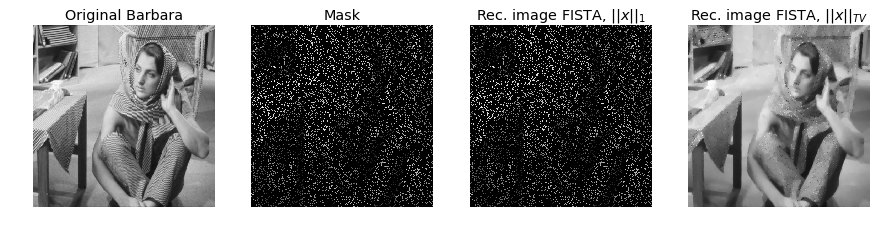

In [57]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(duck, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Barbara')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(im_masked_barbara, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Mask')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_tvnorm_mask_FISTA_barbara1['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image FISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tvnorm_mask_FISTA_barbara['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image FISTA, $\|\| x \|\|_{TV}$')


plt.savefig('MASK_BARBARA____6666_FISTA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

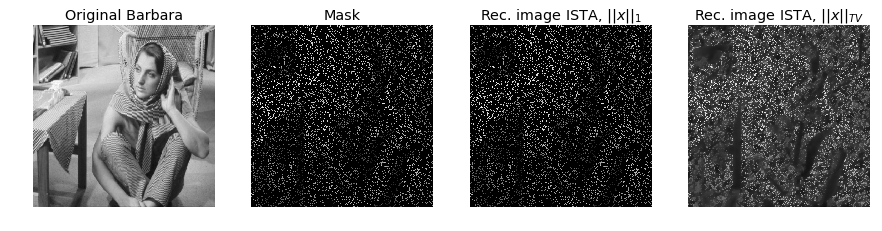

In [58]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(duck, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Barbara')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(im_masked_barbara, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Mask')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_tvnorm_mask_ISTA_barbara1['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image ISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tvnorm_mask_ISTA_barbara['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image ISTA, $\|\| x \|\|_{TV}$')


plt.savefig('MASK_BARBARA____6666_ISTA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

____

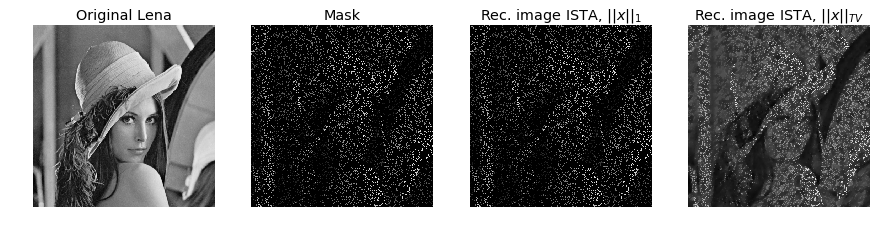

In [59]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Lena')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(im_masked, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Mask')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm_mask_ISTA['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image ISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tvnorm_mask_ISTA['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image ISTA, $\|\| x \|\|_{TV}$')


plt.savefig('MASK_LENO4KA____6666_ISTA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

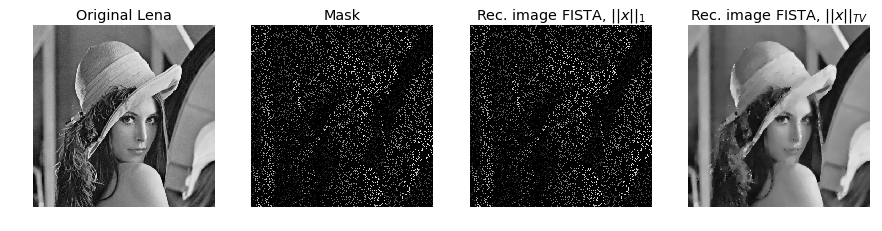

In [60]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Lena')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(im_masked, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Mask')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(ret_1norm_mask_FISTA['sol'], cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image FISTA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(ret_tvnorm_mask_FISTA['sol'], cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image FISTA, $\|\| x \|\|_{TV}$')


plt.savefig('MASK_LENO4KA____6666_FISTA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')

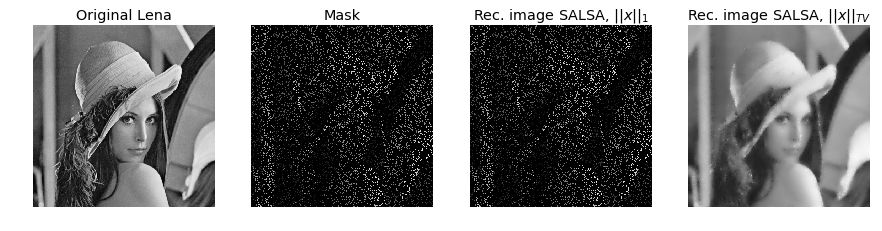

In [61]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 4, 1)
_ = ax1.imshow(x, cmap='gray')
_ = ax1.axis('off')
_ = ax1.set_title('Original Lena')
ax2 = fig.add_subplot(1, 4, 2)
_ = ax2.imshow(im_masked, cmap='gray')
_ = ax2.axis('off')
_ = ax2.set_title('Mask')
ax3 = fig.add_subplot(1, 4, 3)
_ = ax3.imshow(x_salsa_mask_1norm, cmap='gray')
_ = ax3.axis('off')
_ = ax3.set_title('Rec. image SALSA, $\|\| x \|\|_1$')
ax4 = fig.add_subplot(1, 4, 4)
_ = ax4.imshow(x_salsa_mask, cmap='gray')
_ = ax4.axis('off')
_ = ax4.set_title('Rec. image SALSA, $\|\| x \|\|_{TV}$')


plt.savefig('MASK_LENO4KA____6666_SALSA'+ '.pdf', format = 'pdf', bbox_inches = 'tight')